# Disentangled Causal Effect Variational Autoencoder

**Inputs:**
- data/heart_disease_cleaned.csv

**Outputs:**
- DCEVEA model
- data/fair_disease_dcevae.csv
- data/cf_disease_dcevea.csv

## Setup and imports

In [1]:
try:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
except ImportError:
  PROJECT_ROOT = '/'


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as utils
import re
from torch import nn

In [3]:
from argparse import Namespace

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = PROJECT_ROOT + '/models/dcevae.pt'
SEED = 4
BATCH_SIZE = 32
UC_DIM = 3
UD_DIM = 3
H_DIM = 5
ACT_FN = 'relu'
N_EPOCHS = 30
LEARNING_RATE = 0.01
CORR_RECON_ALPHA = 1
DESC_RECON_ALPHA = 1
PRED_ALPHA = 1
FAIR_BETA = 1
TC_BETA = 1

args = Namespace(
    device=DEVICE,
    model_path=MODEL_PATH,
    seed=SEED,
    batch_size=BATCH_SIZE,
    uc_dim=UC_DIM,
    ud_dim=UD_DIM,
    h_dim=H_DIM,
    act_fn=ACT_FN,
    n_epochs=N_EPOCHS,
    lr = LEARNING_RATE,
    corr_a = CORR_RECON_ALPHA,
    desc_a = DESC_RECON_ALPHA,
    pred_a = PRED_ALPHA,
    fair_b = FAIR_BETA,
    tc_b = TC_BETA
)

## Utils

In [4]:
from sklearn.model_selection import train_test_split

def make_loader(X_ind, X_desc, X_corr, X_sens, Y, index, batch_size=32):
  X_ind_fact = X_ind[index]
  X_desc_fact = X_desc[index]
  X_corr_fact = X_corr[index]
  X_sens_fact = X_sens[index]
  Y_fact = Y[index]

  # # Permuted set for the discriminator
  # permuted_indices = np.random.permutation(X_ind_fact.shape[0])
  # X_ind_fake = X_ind[permuted_indices]
  # X_desc_fake = X_desc[permuted_indices]
  # X_corr_fake = X_corr[permuted_indices]
  # X_sens_fake = X_sens[permuted_indices]
  # Y_fake = Y[permuted_indices]

  X_ind_tensor = torch.tensor(X_ind_fact, dtype=torch.float32)
  X_desc_tensor = torch.tensor(X_desc_fact, dtype=torch.float32)
  X_corr_tensor = torch.tensor(X_corr_fact, dtype=torch.float32)
  X_sens_tensor = torch.tensor(X_sens_fact, dtype=torch.float32)
  Y_tensor = torch.tensor(Y_fact, dtype=torch.float32)
  # X_ind_tensor_2 = torch.tensor(X_ind_fake, dtype=torch.float32)
  # X_desc_tensor_2 = torch.tensor(X_desc_fake, dtype=torch.float32)
  # X_corr_tensor_2 = torch.tensor(X_corr_fake, dtype=torch.float32)
  # X_sens_tensor_2 = torch.tensor(X_sens_fake, dtype=torch.float32)
  # Y_tensor_2 = torch.tensor(Y_fake, dtype=torch.float32)

  dataset = utils.TensorDataset(X_ind_tensor, X_desc_tensor, X_corr_tensor, X_sens_tensor, Y_tensor)
  # dataset = utils.TensorDataset(X_ind_tensor, X_desc_tensor, X_corr_tensor, X_sens_tensor, Y_tensor,
  #                               X_ind_tensor_2, X_desc_tensor_2, X_corr_tensor_2, X_sens_tensor_2, Y_tensor_2)
  loader = utils.DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return loader

def make_bucketed_loader(dataset, map, val_size=0.2, test_size=0.1, batch_size=32, seed=4):
  '''
    Creates train, validation and test DataLoader for the given dataset, \
    separating features into independent, sensitive, descendant, and correlated features.

    Input:
      - dataset: a pandas DataFrame
      - map: a dictionary mapping feature names to buckets
      - val_size: the proportion of the dataset to use for validation
      - test_size: the proportion of the dataset to use for testing
      - batch_size: the batch size for the DataLoader
      - seed: a seed for the random number generator

    Output:
      - train_loader: Training DataLoader
      - val_loader: Validation DataLoader
      - test_loader: Testing DataLoader
      - ind_types: a list of the data types of the independent features
      - desc_types: a list of the data types of the descendant features
      - corr_types: a list of the data types of the correlated features
      - sens_type: the data type of the sensitive feature
  '''
  np.random.seed(seed=seed)

  ## BUCKET DATASET
  # Independent, Descendant, Correlated features and Sensitive attributes
  col_ind = []
  for feature in map['ind']:
    col_ind.append(feature['name'])
  X_ind = dataset[col_ind].to_numpy()

  col_desc = []
  for feature in map['desc']:
    col_desc.append(feature['name'])
  X_desc = dataset[col_desc].to_numpy()

  col_corr = []
  for feature in map['corr']:
    col_corr.append(feature['name'])
  X_corr = dataset[col_corr].to_numpy()

  col_sens = []
  for feature in map['sens']:
    col_sens.append(feature['name'])
  X_sens = dataset[col_sens].to_numpy()

  # Target
  Y = dataset[map['target']['name']].to_numpy().reshape(-1, 1)

  ## TRAIN-VAL-TRAIN SPLIT
  # Stratified by target class
  N = X_ind.shape[0]
  indices = np.arange(N)
  train_val_idx, test_index = train_test_split(
      indices,
      test_size=test_size,
      random_state=seed,
      stratify=Y
  )
  train_index, val_index = train_test_split(
      train_val_idx,
      test_size=val_size/(1 - test_size),
      random_state=seed,
      stratify=Y[train_val_idx]
  )

  # Training loader
  train_loader = make_loader(X_ind, X_desc, X_corr, X_sens, Y, train_index, batch_size)

  # Validation loader
  val_loader = make_loader(X_ind, X_desc, X_corr, X_sens, Y, val_index, batch_size)

  # Test loader
  test_loader = make_loader(X_ind, X_desc, X_corr, X_sens, Y, test_index, batch_size)

  return train_loader, val_loader, test_loader

## DCEVEA Architecture

### Network architecture

### Network objectives

The DCEVAE network uses a min-max core objective structure to minimize the negative Evidence Lower Bound (ELBO) and Total Correlation loss ($\mathcal{L}_{TC}$), while maximising the objective of the discriminator ($M_D$):

$$min_{\theta, \phi}\mathcal{L}_{DCEVAE} := - \mathcal{M}_{ELBO} + \beta_{TC}\mathcal{L}_{TC}$$

$$max_{\psi}\mathcal{M}_D$$

- θ and ϕ are the paramaters for the decoder $q_{\theta}$ and encoder $p_{\phi}$ networks respectively
- ψ represents the parameters of the discriminator network $D_{\psi}$
- $\beta_{TC}$ is the Total Correlation scaling parameter

#### ELBO

Measures how well the decoder reconstructs the inputs (Expected Log-Likelihood, to be maximised) and how close the encoder's distribution of the latent variable is to a standard prior distribution (KL Divergence, to be minimised)

$$ELBO = \mathbb{E}_{q_{\phi}(u_d|s,x_i,x_d,y)q_{\phi}(u_c|s,x_i,x_c,y)}[\log p_{\theta}(y|s,x_i,u_d,u_c)]+\mathbb{E}_{q_{\phi}(u_d|s,x_i,x_d,y)}[\log p_{\theta}(y|s,x_i,u_d)]+\mathbb{E}_{q_{\phi}(u_c|s,x_i,x_c,y)}[\log p_{\theta}(y|s,x_i,u_c)]-KL(q_{\phi}(u_d|s,x_i,x_d,y)∥p(u_d))-KL(q_{\phi}(u_c|s,x_i,x_c,y)∥ p(u_c))$$

#### Disentanglement Loss
To ensure that the latent variables are properly disentangled from the sensitive attribute, the DCEVAE model minimises the Total Correlation loss approximated by the discriminator:
$$\mathcal{L}_{TC} \approx \mathbb{E}_{q(s,u_d,u_c)}[\log \frac{D_{\psi}(s,u_d,u_c)}{1-D_{\psi}(s,u_d,u_c)}]$$

while the discriminator maximises its adversary objective:

$$M_D = \mathbb{E}_{q(s,u_d,u_c)}[\log(D_{\psi}(s,u_d,u_c))]+\mathbb{E}_{q(s,u_c)q(u_d)}[\log(1-D_{\psi}(s,u_d,u_c))]$$




## DCEVAE Model Class

In [5]:
class DCEVAE(nn.Module):
  def __init__(self, ind_meta, desc_meta, corr_meta, sens_meta, args):
    super(DCEVAE, self).__init__()
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

    self.ind_meta = ind_meta
    self.desc_meta = desc_meta
    self.corr_meta = corr_meta
    self.sens_meta = sens_meta

    self.embedding_dim = 3
    self.embeddings = nn.ModuleDict()

    def get_bucket_dim(bucket_meta):
      '''
        Returns the total dimension of the feature bucket
      '''
      total_dim = 0
      for feature in bucket_meta:
        if feature['type'] == 'categorical':
          self.embeddings[feature['name']] = nn.Embedding(feature['n'], self.embedding_dim)
          total_dim += self.embedding_dim
        else:
          total_dim += 1
      return total_dim

    self.ind_dim = get_bucket_dim(ind_meta)
    self.desc_dim = get_bucket_dim(desc_meta)
    self.corr_dim = get_bucket_dim(corr_meta)
    self.sens_dim = get_bucket_dim(sens_meta)
    self.target_dim = 1

    self.args = args
    self.device = args.device
    self.uc_dim = args.uc_dim
    self.ud_dim = args.ud_dim
    self.u_dim = self.uc_dim + self.ud_dim
    self.h_dim = args.h_dim
    self.batch_size = args.batch_size

    # Activation function
    if (args.act_fn == 'relu'):
      self.act_fn = nn.LeakyReLU()
    elif (args.act_fn == 'tanh'):
      self.act_fn = nn.Tanh()

    # Encoder (X_ind, X_corr, X_sens, Y) -> U_c
    input_dim = self.ind_dim + self.corr_dim + self.sens_dim + self.target_dim
    self.encoder_corr = nn.Sequential(
        nn.Linear(input_dim, self.h_dim),
        self.act_fn,
        nn.Linear(self.h_dim, self.h_dim),
        self.act_fn
    )
    self.mu_corr = nn.Linear(self.h_dim, self.uc_dim)
    self.logvar_corr = nn.Linear(self.h_dim, self.uc_dim)

    # Encoder (X_ind, X_desc, X_sens, Y) -> U_d
    input_dim = self.ind_dim + self.desc_dim + self.sens_dim + self.target_dim
    self.encoder_desc = nn.Sequential(
        nn.Linear(input_dim, self.h_dim),
        self.act_fn,
        nn.Linear(self.h_dim, self.h_dim),
        self.act_fn
    )
    self.mu_desc = nn.Linear(self.h_dim, self.ud_dim)
    self.logvar_desc = nn.Linear(self.h_dim, self.ud_dim)

    # Decoder (U_c, X_ind) -> X_corr
    self.decoder_corr = nn.ModuleDict()
    for feature in corr_meta:
      out_dim = 1 if feature['type'] != 'categorical' else feature.get('n')
      self.decoder_corr[feature['name']] = nn.Sequential(
          nn.Linear(self.uc_dim + self.ind_dim, self.h_dim),
          self.act_fn,
          nn.Linear(self.h_dim, out_dim)
      )

    # Decoder (U_desc, X_ind, X_sens) -> X_desc
    self.decoder_desc = nn.ModuleDict()
    for feature in desc_meta:
      out_dim = 1 if feature['type'] != 'categorical' else feature.get('n')
      self.decoder_desc[feature['name']] = nn.Sequential(
          nn.Linear(self.ud_dim + self.ind_dim + self.sens_dim , self.h_dim),
          self.act_fn,
          nn.Linear(self.h_dim, out_dim)
      )

    # Decoder (U_desc, U_corr, X_ind, X_sens) -> Y
    self.decoder_target = nn.Sequential(
        nn.Linear(self.u_dim + self.ind_dim + self.sens_dim, self.h_dim),
        self.act_fn,
        nn.Linear(self.h_dim, self.target_dim)
    )

    # Discriminator
    self.discriminator = nn.Sequential(
        nn.Linear(self.u_dim + self.sens_dim, self.h_dim),
        nn.LeakyReLU(0.2, True),
        nn.Linear(self.h_dim, self.h_dim),
        nn.LeakyReLU(0.2, True),
        nn.Linear(self.h_dim, self.h_dim),
        nn.LeakyReLU(0.2, True),
        nn.Linear(self.h_dim, 2)
    )

    self.init_params()

  def init_params(self):
    '''
      Initialise the network parameters.
    '''
    main_act_fn = "tanh" if isinstance(self.act_fn, nn.Tanh) else "relu"

    for name, module in self.named_modules():
      if isinstance(module, nn.Linear):
        if "discriminator" in name:
          # Kaiming normal for the LeakyReLU in the Discriminator
          nn.init.kaiming_normal_(module.weight, a=0.2, nonlinearity="leaky_relu")
        else:
          # Xavier normal for Tanh, Kaiming normal for LeakyReLU in the encoders/decoders
          if main_act_fn == "tanh":
            nn.init.xavier_normal(module.weight)
          else:
            nn.init.kaiming_normal_(module.weight, a=0.01, nonlinearity="leaky_relu")

        if module.bias is not None:
          nn.init.constant_(module.bias, 0)

  def discriminate(self, v):
    '''
      Discriminator forward pass
    '''
    return self.discriminator(v).squeeze()

  def _process_features(self, x, x_meta):
    '''
      Processes the input features by applying embeddings to the categorical columns
    '''
    processed = []
    for i, feature in enumerate(x_meta):
      col = x[:, i]
      if feature['type'] == 'categorical':
        processed.append(self.embeddings[feature['name']](col.long()))
      else:
        processed.append(col.unsqueeze(1))
    return torch.cat(processed, dim=1)

  def encode(self, x_ind, x_desc, x_corr, x_sens, y):
    '''
      Encoders forward pass
    '''
    # Process raw tensors
    x_ind_p = self._process_features(x_ind, self.ind_meta)
    x_desc_p = self._process_features(x_desc, self.desc_meta)
    x_corr_p = self._process_features(x_corr, self.corr_meta)
    x_sens_p = self._process_features(x_sens, self.sens_meta)

    # Correlated path encoder
    input_corr = torch.cat((x_ind_p, x_corr_p, x_sens_p, y), dim=1)
    h_corr = self.encoder_corr(input_corr)
    mu_corr = self.mu_corr(h_corr)
    logvar_corr = self.logvar_corr(h_corr)

    # Descendant path encoder
    input_desc = torch.cat((x_ind_p, x_desc_p, x_sens_p, y), dim=1)
    h_desc = self.encoder_desc(input_desc)
    mu_desc = self.mu_desc(h_desc)
    logvar_desc = self.logvar_desc(h_desc)

    return mu_corr, logvar_corr, mu_desc, logvar_desc

  def decode(self, u_desc, u_corr, x_ind, x_sens):
    '''
      Decoders forward pass
    '''
    # Process raw tensors
    x_ind_p = self._process_features(x_ind, self.ind_meta)
    x_sens_p = self._process_features(x_sens, self.sens_meta)

    # Correlated path
    input_corr = torch.cat((u_corr, x_ind_p), dim=1)
    x_corr_pred = {feature['name']: self.decoder_corr[feature['name']](input_corr)\
                   for feature in self.corr_meta}

    # Descendant path
    input_desc = torch.cat((u_desc, x_ind_p, x_sens_p), dim=1)
    x_desc_pred = {feature['name']: self.decoder_desc[feature['name']](input_desc)\
                   for feature in self.desc_meta}

    # Target
    input_target = torch.cat((u_desc, u_corr, x_ind_p, x_sens_p), dim=1)
    y_pred = self.decoder_target(input_target)

    # Counterfactual
    x_sens_cf_p = self._process_features(1 - x_sens, self.sens_meta)
    input_desc_cf = torch.cat((u_desc, x_ind_p, x_sens_cf_p), dim=1)
    x_desc_cf = {feature['name']: self.decoder_desc[feature['name']](input_desc_cf)\
                   for feature in self.desc_meta}

    input_target_cf = torch.cat((u_desc, u_corr, x_ind_p, x_sens_cf_p), dim=1)
    y_cf = self.decoder_target(input_target_cf)

    return x_corr_pred, x_desc_pred, y_pred, x_desc_cf, y_cf

  def reparameterize(self, mu, logvar):
    '''
      Reparameterisation trick
    '''
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(self.device)
    return mu + eps * std

  def reconstruction_loss(self, v_pred, v, v_meta):
    '''
      Calculates the total reconstruction loss for the given feature bucket,\
       matching each feature type to the correct loss function
    '''
    sample_size = v.size(0)
    total_recon_L = 0
    for i, feature in enumerate(v_meta):
      pred = v_pred[feature['name']]
      target = v[:, i]

      if feature['type'] == 'categorical':
        total_recon_L += nn.CrossEntropyLoss(reduction='sum')(pred, target.long())
      elif feature['type'] == 'binary':
        total_recon_L += nn.BCEWithLogitsLoss(reduction='sum')(pred, target.unsqueeze(1))
      else:
        total_recon_L += nn.MSELoss(reduction='sum')(pred, target.unsqueeze(1))

    return total_recon_L / sample_size

  def kl_loss(self, mu, logvar):
    '''
      Calculates the KL divergence for the given latent variable between the \
      approzimate posterior q(u|x,y,a) and the standard normal prior p(u) = N(0,I)
    '''
    logvar_clamped = torch.clamp(logvar, -10.0, 10.0)

    kl_div = -0.5 * torch.sum(1 + logvar_clamped - mu.pow(2) - logvar_clamped.exp())

    return kl_div / mu.size(0)

  def tc_loss(self, u_desc, u_corr, x_sens):
    '''
      Calculates the Total Correlation loss to minimise for the VAE and the \
      discriminator loss
    '''
    sample_size = u_desc.size(0)

    # Process raw tensors
    x_sens_p = self._process_features(x_sens, self.sens_meta)

    # Run the discriminator on factual samples
    input_disc = torch.cat((u_desc, u_corr, x_sens_p), dim=1)
    disc_logits = self.discriminator(input_disc)

    # Prepare permuted samples
    permuted_indices = np.random.permutation(u_desc.size(0))
    u_desc_permuted = u_desc[permuted_indices]

    # Run the discriminator on permuted samples
    input_disc_permuted = torch.cat((u_desc_permuted, u_corr, x_sens_p), dim=1)
    disc_logits_permuted = self.discriminator(input_disc_permuted)

    # Calculate the TC loss to minimise for the VAE
    tc_L = (disc_logits[:, 1] - disc_logits[:, 0]).mean()

    # Calculate the discriminator loss
    target_real = torch.ones(sample_size, dtype=torch.long).to(self.device)
    target_fake = torch.zeros(sample_size, dtype=torch.long).to(self.device)
    disc_L = nn.CrossEntropyLoss()(disc_logits, target_real) + nn.CrossEntropyLoss()(disc_logits_permuted, target_fake)

    return tc_L, disc_L

  def fair_loss(self, y, y_cf):
    y_cf_sig = nn.Sigmoid()(y_cf)
    y_p_sig = nn.Sigmoid()(y)
    fair_L = torch.sum(torch.norm(y_cf_sig - y_p_sig, p=2, dim=1))/y_cf_sig.size(0)
    return fair_L

  def calculate_loss(self, x_ind, x_desc, x_corr, x_sens, y):

    # Encode
    mu_corr, logvar_corr, mu_desc, logvar_desc = self.encode(
        x_ind, x_desc, x_corr, x_sens, y)

    # Reparamaterise
    u_corr = self.reparameterize(mu_corr, logvar_corr)
    u_desc = self.reparameterize(mu_desc, logvar_desc)

    # Decode
    x_corr_pred, x_desc_pred, y_pred, x_desc_cf, y_cf = self.decode(
        u_desc, u_corr, x_ind, x_sens)

    # Reconstruction & prediction loss
    desc_recon_L = self.reconstruction_loss(x_desc_pred, x_desc, self.desc_meta)
    corr_recon_L = self.reconstruction_loss(x_corr_pred, x_corr, self.corr_meta)
    y_recon_L = nn.BCEWithLogitsLoss()(y_pred, y)

    recon_L = self.args.desc_a*desc_recon_L + self.args.corr_a*corr_recon_L + self.args.pred_a*y_recon_L

    # KL loss
    kl_L = self.kl_loss(mu_corr, logvar_corr) + self.kl_loss(mu_desc, logvar_desc)

    # TC loss
    tc_L, disc_L = self.tc_loss(u_desc, u_corr, x_sens)

    # Counterfactual fairness loss
    fair_L = self.fair_loss(y_pred, y_cf)

    # Total VAE obective
    # Fair Disentangled Negative ELBO = -M_ELBO + beta_tc * L_TC + beta_f * L_f
    total_vae_loss = recon_L + kl_L + self.args.tc_b*tc_L + self.args.fair_b*fair_L

    return total_vae_loss, disc_L, desc_recon_L, corr_recon_L, y_recon_L, kl_L, tc_L, fair_L



## Data preparation

In [6]:
heart_disease = pd.read_csv(PROJECT_ROOT + '/data/heart_disease_cleaned.csv',
                            dtype={'cp':int, 'ang':int, 'ecg':int, 'fbs':int, 'slope':int})

feature_mapping = {
    'ind': [{'name':'age','type':'continuous'}], # Features independent of the protected attribute and unconfounded
    'desc': [
        {'name':'ang','type':'binary'},
        {'name':'cp','type':'categorical', 'n':4},
        {'name':'ecg','type':'categorical','n':3}], # Features descendant of the protected attribute
    'corr': [
        {'name':'bp','type':'continuous'},
        {'name':'chol','type':'continuous'},
        {'name':'mhr','type':'continuous'},
        {'name':'st','type':'continuous'},
        {'name':'fbs','type':'binary'},
        {'name':'slope','type':'categorical', 'n':3}], # Features correlated with the protected attribute
    'sens': [{'name':'sex','type':'binary'}], # Sensitive attribute
    'target': {'name':'cvd','type':'binary'} # Target outcome
}

# Bucketed data loaders for training , validation, and test
train_loader, val_loader, test_loader = make_bucketed_loader(heart_disease, feature_mapping)


## Model training

In [7]:
import torch.optim as optim

# Instantiate the DCEVAE model
model = DCEVAE(feature_mapping['ind'], feature_mapping['desc'], feature_mapping['corr'],
               feature_mapping['sens'], args=args)

# Training
model.to(args.device)
model = model.train()

discrim_params = [param for name, param in model.named_parameters() if 'discriminator' in name]
main_params = [param for name, param in model.named_parameters() if 'discriminator' not in name]
discrim_optimiser = optim.Adam(discrim_params, lr=args.lr)
main_optimiser = optim.Adam(main_params, lr=args.lr)

epochs_log = []
train_metrics_log = []

for epoch in range(args.n_epochs):

  train_metrics = {
      'elbo': [],
      'desc_recon_L': [],
      'corr_recon_L': [],
      'y_recon_L': [],
      'tc_L': [],
      'fair_L': [],
      'disc_L': []
  }

  model.train()
  for i, batch in enumerate(train_loader):
    x_ind, x_desc, x_corr, x_sens, y =\
    [tensor.to(args.device) for tensor in batch[:5]]

    # Reset optimiser gradients
    discrim_optimiser.zero_grad()
    main_optimiser.zero_grad()

    # Forward pass and loss calculation
    elbo, disc_L, desc_recon_L, corr_recon_L, y_recon_L, kl_L, tc_L, fair_L \
      = model.calculate_loss(x_ind, x_desc, x_corr, x_sens, y)

    # Discriminator backpropagation
    disc_L.backward(retain_graph=True)

    # Clear VAE optimiser gradient again
    main_optimiser.zero_grad()

    # VAE backpropagation
    elbo.backward()

    # Step both optimisers
    discrim_optimiser.step()
    main_optimiser.step()

    # Log metrics
    train_metrics['elbo'].append(elbo.item())
    train_metrics['desc_recon_L'].append(desc_recon_L.item())
    train_metrics['corr_recon_L'].append(corr_recon_L.item())
    train_metrics['y_recon_L'].append(y_recon_L.item())
    train_metrics['tc_L'].append(tc_L.item())
    train_metrics['fair_L'].append(fair_L.item())
    train_metrics['disc_L'].append(disc_L.item())

  # Epoch summary
  avg_train_loss = np.mean(train_metrics['elbo'])
  epochs_log.append({'avg_train_loss':avg_train_loss})

  epochs_log[-1]['avg_disc_loss'] = np.mean(train_metrics["disc_L"])
  epochs_log[-1]['avg_tc_loss'] = np.mean(train_metrics["disc_L"])
  epochs_log[-1]['avg_fair_loss'] = np.mean(train_metrics["fair_L"])

  # Validation
  model.eval()
  val_elbo = []
  with torch.no_grad():
    for i, batch in enumerate(val_loader):
      x_ind, x_desc, x_corr, x_sens, y =\
        [tensor.to(args.device) for tensor in batch[:5]]
      v_elbo, *_ = model.calculate_loss(x_ind, x_desc, x_corr, x_sens, y)
      val_elbo.append(v_elbo.item())

  avg_val_loss = np.mean(val_elbo)
  epochs_log[-1]['avg_val_loss'] = avg_val_loss

  train_metrics_log.append(train_metrics)

  # print(f'Epoch {epoch}: Val VAE Loss: {avg_val_loss:.4f} - Train VAE Loss: {avg_train_loss:.4f}')


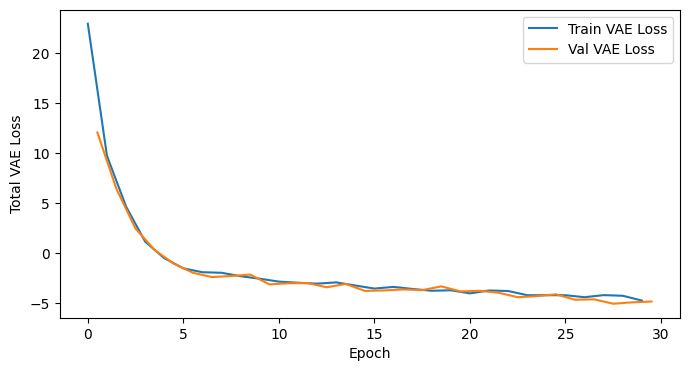

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs_metrics = pd.DataFrame(epochs_log)

fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=epochs_metrics.index, y=epochs_metrics["avg_train_loss"], ax=ax, label='Train VAE Loss', errorbar=None)
sns.lineplot(x=epochs_metrics.index+.5, y=epochs_metrics["avg_val_loss"], ax=ax, label='Val VAE Loss', errorbar=None)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Total VAE Loss')
plt.show()

## Model evaluation

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

model.eval()

all_y_true, all_y_pred_prob, all_y_cf_prob, all_sens = [], [], [], []

with torch.no_grad():
  for batch in test_loader:
    x_ind, x_desc, x_corr, x_sens, y = [t.to(args.device) for t in batch[:5]]

    # Infer latent variables
    mu_corr, logvar_corr, mu_desc, logvar_desc = model.encode(x_ind, x_desc, x_corr, x_sens, y)

    # Factual and Counterfactual prediction
    # using the mean u_corr and u_desc
    u_corr = mu_corr
    u_desc = mu_desc

    _, _, y_pred_prob, _, y_cf_prob = model.decode(u_desc, u_corr, x_ind, x_sens)

    all_y_true.append(y.cpu().numpy())
    all_y_pred_prob.append(torch.sigmoid(y_pred_prob).cpu().numpy())
    all_y_cf_prob.append(torch.sigmoid(y_cf_prob).cpu().numpy())
    all_sens.append(x_sens.cpu().numpy())

test_results = pd.DataFrame({
    'y_true': np.concatenate(all_y_true).flatten(),
    'y_pred_prob': np.concatenate(all_y_pred_prob).flatten(),
    'y_cf_prob': np.concatenate(all_y_cf_prob).flatten(),
    'sens': np.concatenate(all_sens).flatten()
})
test_results['y_pred'] = (test_results['y_pred_prob'] > 0.5).astype(int)

test_results.head()

print(f'Test Accuracy: {accuracy_score(test_results['y_true'], test_results['y_pred'])}')
print(f'Test AUC: {roc_auc_score(test_results["y_true"], test_results["y_pred_prob"])}')


Test Accuracy: 0.8533333333333334
Test AUC: 0.962962962962963
